In [1]:
# check gpu availability
import torch

# print the name of the GPU
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650 SUPER'

In [2]:
# load data and split into train and test sets
from load_data import sim_arr
from sklearn.model_selection import train_test_split

# reshape from batch, height, width, channel, to batch, channel, height, width
sim_arr_transformed = sim_arr.reshape(
    sim_arr.shape[0], sim_arr.shape[3], sim_arr.shape[1], sim_arr.shape[2])
train_set, test_set = train_test_split(
    sim_arr_transformed, test_size=0.2, random_state=42)

# convert to tensor
train_set = torch.tensor(train_set, dtype=torch.float32)
test_set = torch.tensor(test_set, dtype=torch.float32)

In [3]:
from AE_torch import Autoencoder
from search_space import search_space
import optuna
import warnings
import torch.nn as nn


def objective(trial):
    #clear clutter from previous runs
    torch.cuda.empty_cache()

    # define search space
    num_layers, poolsize, channels, kernel_sizes, dilations, paddings, activations = search_space(trial, input_dim=3, output_dim=3)
    # conert activation strings to classes
    activations = [eval(activation) for activation in activations]

    # define model
    model = Autoencoder(num_layers=num_layers,
                        poolsize=poolsize,
                        channels=channels,
                        kernel_sizes=kernel_sizes,
                        dilations=dilations,
                        paddings=paddings,
                        activations=activations,
                        epochs=100,
                        batch_size=32,
                        learning_rate=1e-3,
                        data=train_set)
    
    # train model with k-fold cross validation
    val_losses = model.cross_val()
    val_loss = sum(val_losses) / len(val_losses)
    print("Validation loss:", val_loss)
    return val_loss

# delete the study
#optuna.delete_study(study_name="autoencoder_torch1", storage="sqlite:///autoencoder.db")

# define study
study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name="autoencoder_torch1",
                            storage="sqlite:///autoencoder.db",
                            load_if_exists=True)

study.optimize(objective, n_trials=1)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", str(best_params))
print("Best value:", study.best_value)
warnings.filterwarnings("ignore")


[I 2024-05-02 06:43:00,999] Using an existing study with name 'autoencoder_torch1' instead of creating a new one.
/home/tux/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 10] which is of type list.
  warnings.warn(message)
/home/tux/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 10, 2] which is of type list.
  warnings.warn(message)
/home/tux/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage b

Fold 1/5
torch.Size([1, 3, 80, 80]) Conv2d(3, 9, kernel_size=(11, 11), stride=(1, 1), padding=(20, 20), dilation=(4, 4))
torch.Size([1, 9, 80, 80]) Tanh()
torch.Size([1, 9, 80, 80]) MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=True)
torch.Size([1, 9, 16, 16]) Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 12, 16, 16]) SiLU()
torch.Size([1, 12, 16, 16]) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
torch.Size([1, 12, 8, 8]) Conv2d(12, 3, kernel_size=(24, 24), stride=(1, 1), padding=(11, 11))
torch.Size([1, 3, 7, 7]) SiLU()
torch.Size([1, 3, 7, 7]) MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=True)
torch.Size([1, 3, 1, 1]) Upsample(scale_factor=8.0, mode='nearest')
torch.Size([1, 3, 8, 8]) SiLU()
torch.Size([1, 3, 8, 8]) ConvTranspose2d(3, 12, kernel_size=(24, 24), stride=(1, 1), padding=(11, 11))


/home/tux/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 20] which is of type list.
  warnings.warn(message)
/home/tux/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 20, 2] which is of type list.
  warnings.warn(message)
/home/tux/hyper-param-optim-4-vector-field-clustering/.venv/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [20, 2, 2] which is of type list.
  warnings.warn(message)
/home/tux/hyper-param-optim-4-vector-field-cluste

torch.Size([1, 12, 9, 9]) Upsample(scale_factor=2.0, mode='nearest')
torch.Size([1, 12, 18, 18]) SiLU()
torch.Size([1, 12, 18, 18]) ConvTranspose2d(12, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 9, 18, 18]) Upsample(scale_factor=5.0, mode='nearest')
torch.Size([1, 9, 90, 90]) Tanh()
torch.Size([1, 9, 90, 90]) ConvTranspose2d(9, 3, kernel_size=(11, 11), stride=(1, 1), padding=(20, 20), dilation=(4, 4))


ValueError: Output shape does not mutch expected shape.torch.Size([1, 3, 90, 90])

In [ ]:
# train model with best hyperparameters
num_layers, poolsize, channels, kernel_sizes, dilations, paddings, activations = search_space(
    study.best_trial, input_dim=3, output_dim=3)

activations = [eval(activation) for activation in activations]
model = Autoencoder(num_layers=num_layers,
                    poolsize=poolsize,
                    channels=channels,
                    kernel_sizes=kernel_sizes,
                    dilations=dilations,
                    paddings=paddings,
                    activations=activations,
                    epochs=10,
                    batch_size=32, 
                    learning_rate=1e-3,
                    data=train_set)

model.cross_val()

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


[0.21356416608040757,
 0.21148540305275146,
 0.21130259814227764,
 0.2123961431011093,
 0.20999699037932557]

In [ ]:
# summarize the model
print(model)

Autoencoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv2d(3, 8, kernel_size=(19, 19), stride=(1, 1), padding=(18, 18), dilation=(2, 2))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=True)
      (3): Conv2d(8, 10, kernel_size=(6, 6), stride=(1, 1), padding=(5, 5), dilation=(2, 2))
      (4): SELU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (6): Conv2d(10, 4, kernel_size=(9, 9), stride=(1, 1), padding=(8, 8), dilation=(2, 2))
      (7): SELU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (9): Conv2d(4, 3, kernel_size=(19, 19), stride=(1, 1), padding=(36, 36), dilation=(4, 4))
      (10): SiLU()
      (11): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): ConvTranspose2d(3, 4, kernel_size=(19, 19), stride=(1, 1), padding=(36, 36), d

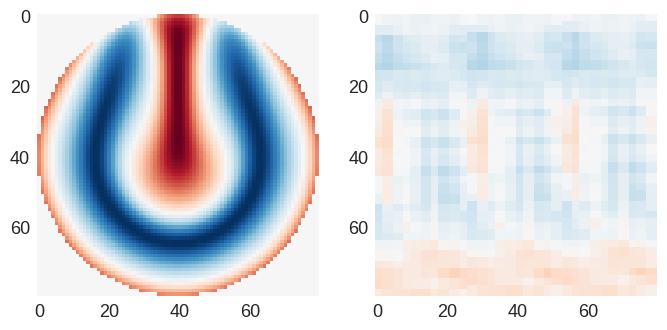

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

i = np.random.randint(0, len(test_set))
in_sim = test_set[i: i + 1]
in_sim = in_sim.to('cuda:0')
out_sim = model(in_sim)
in_sim = in_sim.detach().to('cpu').numpy()
in_sim = in_sim.reshape(in_sim.shape[0], in_sim.shape[2], in_sim.shape[3], in_sim.shape[1])
out_sim = out_sim.detach().to('cpu').numpy()
out_sim = out_sim.reshape(out_sim.shape[0], out_sim.shape[2], out_sim.shape[3], out_sim.shape[1])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")